In [1]:
import torch
print(torch.__version__)

import torchvision

print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")

# Set the target device
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")


2.5.1+cu121
PyTorch version: 2.5.1+cu121
TorchVision version: 0.20.1+cu121
Using device: cuda


In [2]:
import torch
import torchvision

print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")

# Set the target device
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

PyTorch version: 2.5.1+cu121
TorchVision version: 0.20.1+cu121
Using device: cuda


In [3]:
import torch

# Check PyTorch version
pt_version = torch.__version__
print(f"[INFO] Current PyTorch version: {pt_version} (should be 2.x+)")

# Install PyTorch 2.0 if necessary
if pt_version.split(".")[0] == "1": # Check if PyTorch version begins with 1
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    print("[INFO] PyTorch 2.x installed, if you're on Google Colab, you may need to restart your runtime.\
          Though as of April 2023, Google Colab comes with PyTorch 2.0 pre-installed.")
    import torch
    pt_version = torch.__version__
    print(f"[INFO] Current PyTorch version: {pt_version} (should be 2.x+)")
else:
    print("[INFO] PyTorch 2.x installed, you'll be able to use the new features.")

[INFO] Current PyTorch version: 2.5.1+cu121 (should be 2.x+)
[INFO] PyTorch 2.x installed, you'll be able to use the new features.


In [4]:
import torch
import torchvision

print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")

# Set the target device
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

PyTorch version: 2.5.1+cu121
TorchVision version: 0.20.1+cu121
Using device: cuda


In [5]:
def create_model(num_classes=10):
  """
  Creates a ResNet50 model with the latest weights and transforms via torchvision.
  """
  model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
  transforms = model_weights.transforms()
  model = torchvision.models.resnet50(weights=model_weights)

  # Adjust the number of output features in model to match the number of classes in the dataset
  model.fc = torch.nn.Linear(in_features=2048,
                             out_features=num_classes)
  return model, transforms

model, transforms = create_model()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 110MB/s]


In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = 128

In [7]:
transforms.crop_size = IMAGE_SIZE
transforms.resize_size = IMAGE_SIZE
print(f"Updated data transforms:\n{transforms}")

Updated data transforms:
ImageClassification(
    crop_size=128
    resize_size=128
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [8]:
# Create train and test datasets
train_dataset = torchvision.datasets.CIFAR10(root='.',
                                             train=True,
                                             download=True,
                                             transform=transforms)

test_dataset = torchvision.datasets.CIFAR10(root='.',
                                            train=False, # want the test split
                                            download=True,
                                            transform=transforms)

# Get the lengths of the datasets
train_len = len(train_dataset)
test_len = len(test_dataset)

print(f"[INFO] Train dataset length: {train_len}")
print(f"[INFO] Test dataset length: {test_len}")

100%|██████████| 170M/170M [00:05<00:00, 28.5MB/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified
[INFO] Train dataset length: 50000
[INFO] Test dataset length: 10000


In [9]:
class_names=train_dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [10]:
from torch.utils.data import DataLoader

# Create DataLoaders
# - use all available CPU cores (this number can be tweaked through experimentation but generally more workers means faster dataloading from CPU to GPU)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              )

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              )

# Print details
print(f"Train dataloader length: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"Test dataloader length: {len(test_dataloader)} batches of size {BATCH_SIZE}")


Train dataloader length: 1563 batches of size 32
Test dataloader length: 313 batches of size 32


In [11]:
import time
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(epoch: int,
               model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
        enumerate(dataloader),
        desc=f"Training Epoch {epoch}",
        total=len(dataloader),
        disable=disable_progress_bar
    )

  for batch, (X, y) in progress_bar:
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metrics across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

      # Update progress bar
      progress_bar.set_postfix(
            {
                "train_loss": train_loss / (batch + 1),
                "train_acc": train_acc / (batch + 1),
            }
        )


  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(epoch: int,
              model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device,
              disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
      enumerate(dataloader),
      desc=f"Testing Epoch {epoch}",
      total=len(dataloader),
      disable=disable_progress_bar
  )

  # Turn on inference context manager
  with torch.no_grad(): # no_grad() required for PyTorch 2.0, I found some errors with `torch.inference_mode()`, please let me know if this is not the case
      # Loop through DataLoader batches
      for batch, (X, y) in progress_bar:
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

          # Update progress bar
          progress_bar.set_postfix(
              {
                  "test_loss": test_loss / (batch + 1),
                  "test_acc": test_acc / (batch + 1),
              }
          )

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          disable_progress_bar: bool = False) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
      "train_epoch_time": [],
      "test_epoch_time": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs), disable=disable_progress_bar):

      # Perform training step and time it
      train_epoch_start_time = time.time()
      train_loss, train_acc = train_step(epoch=epoch,
                                        model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device,
                                        disable_progress_bar=disable_progress_bar)
      train_epoch_end_time = time.time()
      train_epoch_time = train_epoch_end_time - train_epoch_start_time

      # Perform testing step and time it
      test_epoch_start_time = time.time()
      test_loss, test_acc = test_step(epoch=epoch,
                                      model=model,
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      device=device,
                                      disable_progress_bar=disable_progress_bar)
      test_epoch_end_time = time.time()
      test_epoch_time = test_epoch_end_time - test_epoch_start_time

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"train_epoch_time: {train_epoch_time:.4f} | "
          f"test_epoch_time: {test_epoch_time:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      results["train_epoch_time"].append(train_epoch_time)
      results["test_epoch_time"].append(test_epoch_time)

  # Return the filled results at the end of the epochs
  return results

In [12]:
# Set the number of epochs as a constant
NUM_EPOCHS = 5

# Set the learning rate as a constant (this can be changed to get better results but for now we're just focused on time)
LEARNING_RATE = 0.003

In [13]:
# Create model
model, transforms = create_model()
model.to(device)

# Create loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Train model and track results
single_run_no_compile_results = train(model=model,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      epochs=NUM_EPOCHS,
                                      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0687 | train_acc: 0.6209 | test_loss: 0.8088 | test_acc: 0.7211 | train_epoch_time: 216.3676 | test_epoch_time: 19.4072


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.6448 | train_acc: 0.7767 | test_loss: 0.6962 | test_acc: 0.7610 | train_epoch_time: 216.8112 | test_epoch_time: 19.7215


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.4945 | train_acc: 0.8302 | test_loss: 0.5315 | test_acc: 0.8197 | train_epoch_time: 216.7827 | test_epoch_time: 19.6521


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.3996 | train_acc: 0.8614 | test_loss: 0.5004 | test_acc: 0.8304 | train_epoch_time: 217.1284 | test_epoch_time: 19.8777


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3057 | train_acc: 0.8927 | test_loss: 0.4843 | test_acc: 0.8423 | train_epoch_time: 217.2695 | test_epoch_time: 19.2964


In [49]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [50]:
from torchinfo import summary
summary(model,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],row_settings=["var_names"])

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
ResNet (ResNet)                          [1, 3, 224, 224]          [1, 10]                   --                        True
├─Conv2d (conv1)                         [1, 3, 224, 224]          [1, 64, 112, 112]         9,408                     True
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]         [1, 64, 112, 112]         128                       True
├─ReLU (relu)                            [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]         [1, 64, 56, 56]           --                        --
├─Sequential (layer1)                    [1, 64, 56, 56]           [1, 256, 56, 56]          --                        True
│    └─Bottleneck (0)                    [1, 64, 56, 56]           [1, 256, 56, 56]          --                        True
│    │ 

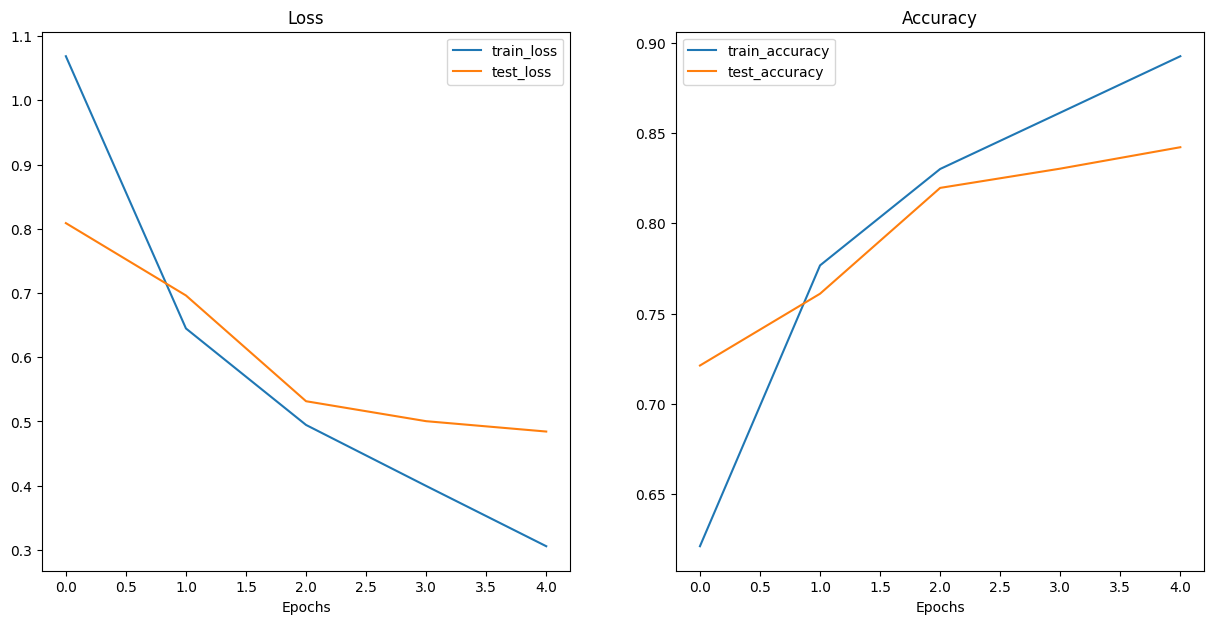

In [51]:
from helper_functions import plot_loss_curves
plot_loss_curves(single_run_no_compile_results)

In [52]:


from going_modular.going_modular import utils
utils.save_model(model=model,target_dir="models",
                 model_name="resnet_model.pth")

[INFO] Saving model to: models/resnet_model.pth


In [53]:
loaded,loaded_transforms=create_model(num_classes=10)

loaded.load_state_dict(torch.load("models/resnet_model.pth"))

<ipython-input-53-38526c793ab8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded.load_state_dict(torch.load("models/resnet_model.pth"))


<All keys matched successfully>

In [54]:
from pathlib import Path

pretrained_megabytes=Path("models/resnet_model.pth").stat().st_size//(1024*1024)

print(f"suze in  mega  bytes {pretrained_megabytes} MB ")

suze in  mega  bytes 90 MB 


In [55]:
from pathlib import Path
ciphar_10=Path("demos/ciphar_10/")
# make foodvision big demo directory
ciphar_10.mkdir(parents=True,exist_ok=True)
# make food vision big demo example directory
(ciphar_10/"examples").mkdir(parents=True,exist_ok=True)

In [56]:
!ls demos/ciphar_10/

app.py	class_names.txt  examples  model.py  requirements.txt  resnet_model.pth


In [57]:
# download and move example image
!wget https://github.com/AtharvaTaras/Cat-Images-Dataset/raw/master/cute%20cat/Image_100.jpg

!mv Image_100.jpg demos/ciphar_10/examples/Image_100.jpg

--2024-12-26 19:10:57--  https://github.com/AtharvaTaras/Cat-Images-Dataset/raw/master/cute%20cat/Image_100.jpg
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AtharvaTaras/Cat-Images-Dataset/master/cute%20cat/Image_100.jpg [following]
--2024-12-26 19:10:57--  https://raw.githubusercontent.com/AtharvaTaras/Cat-Images-Dataset/master/cute%20cat/Image_100.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139967 (137K) [image/jpeg]
Saving to: ‘Image_100.jpg’

Image_100.jpg       100%[===================>] 136.69K  --.-KB/s    in 0.02s   

2024-12-26 19:10:57 (7.49 MB/s) - ‘Image_100.jpg’ saved [13

In [58]:
!mv models/resnet_model.pth demos/ciphar_10/

In [59]:
class_names_path=ciphar_10/"class_names.txt"
class_names_path

PosixPath('demos/ciphar_10/class_names.txt')

In [60]:
with open(class_names_path,"w") as f:
  print(f"saving class names to {class_names_path}")
  f.write("\n".join(class_names)) #one line per class


saving class names to demos/ciphar_10/class_names.txt


In [61]:
# ab classname.txt se load krkr ceck krkr
with open(class_names_path,"r") as f:
  class_names_loaded=[food for food in f.readlines()]
class_names_loaded[:10]

['airplane\n',
 'automobile\n',
 'bird\n',
 'cat\n',
 'deer\n',
 'dog\n',
 'frog\n',
 'horse\n',
 'ship\n',
 'truck']

In [62]:

%%writefile demos/ciphar_10/model.py
import torch
from torch import nn
import torchvision

import torchvision.transforms as T
from torchvision.models import resnet50, ResNet50_Weights


import torchvision.transforms as T

def create_model(num_classes=10):
  """
  Creates a ResNet50 model with the latest weights and transforms via torchvision.
  """
  model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
  transforms = model_weights.transforms()
  model = torchvision.models.resnet50(weights=model_weights)

  # Adjust the number of output features in model to match the number of classes in the dataset
  model.fc = torch.nn.Linear(in_features=2048,
                             out_features=num_classes)
  return model, transforms



Overwriting demos/ciphar_10/model.py


In [63]:
%%writefile demos/ciphar_10/app.py
# 1
import gradio as gr
import os
import torch
from model import create_model
from timeit import default_timer as timer
from typing import Tuple, Dict
# setup class names
with open("class_names.txt", "r") as f:
    class_names = [food_name.strip() for food_name in f.readlines()]
# model and transforms
model,model_transforms=create_model(num_classes=10)
# load the save weights
model.load_state_dict(
    torch.load(f="resnet_model.pth",
               map_location=torch.device("cpu"))
)
# predict func
def predict(img):
    try:
        # Check if image is received
        if img is None:
            return "No image uploaded!", 0.0

        # Model loading (assuming effnetb2 is defined in create_model)
        model, model_transforms = create_model(num_classes=10)
        model.load_state_dict(
            torch.load(f="resnet_model.pth", map_location=torch.device("cpu"))
        )

        start_time = timer()
        img = model_transforms(img).unsqueeze(0)  # Add batch dim
        model.eval()
        with torch.inference_mode():
            pred_logit = model(img)
            pred_probs = torch.softmax(pred_logit, dim=1)
            pred_labels_and_probs = {
                class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))
            }
            end_time = timer()
            pred_time = round(end_time - start_time, 4)
        return pred_labels_and_probs, pred_time
    except Exception as e:
        return f"An error occurred: {str(e)}", 0.0


# 4gradip app
import gradio as gr
title="CIFAR-10"
description="Classify images into 10 CIFAR-10 classes using a ResNet50 model. Quick, accurate, and a great demonstration of computer vision in action "
# example list
# getting list of list

example_list=[["examples/"+example]for example in os.listdir("examples")]
# craete the gradient demo
demo=gr.Interface(fn=predict, #maps input to output
                  inputs=gr.Image(type="pil"),
                  outputs=[gr.Label(num_top_classes=3,label="Predictions"),
                           gr.Number(label="Prediction time(s)")],
                           examples=example_list,
                           title=title,
                           description=description

                  )
# launch it
demo.launch(
    debug=False

    # preints error locally? like in googlr collab
    # generate link publicaly like share with public
)


Overwriting demos/ciphar_10/app.py


In [64]:
%%writefile demos/ciphar_10/requirements.txt
torch
torchvision
gradio

Overwriting demos/ciphar_10/requirements.txt


In [65]:
# wese bhi download krlo
# mgr yhn code se zip krkr download krre
!cd demos/ciphar_10 && zip -r ../ciphar_10.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints"

updating: app.py (deflated 58%)
updating: class_names.txt (deflated 10%)
updating: examples/ (stored 0%)
updating: model.py (deflated 57%)
updating: requirements.txt (deflated 4%)
updating: resnet_model.pth (deflated 7%)
updating: examples/Image_100.jpg (deflated 1%)
